In [1]:
import itertools, numpy as np, pandas as pd
import statsmodels.formula.api as smf
from sklearn.model_selection import LeaveOneOut
from statsmodels.stats.multitest import multipletests
from scipy import stats
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, brier_score_loss, roc_curve, confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_recall_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
from patsy import dmatrices

In [2]:
# import csv file
df = pd.read_csv("Pitchers.csv", index_col = "player_name")

In [3]:
# Adding the column of K% - BB% 
df["pre_k_minus_bb_pct"] = df["pre_k_pct"] - df["pre_bb_pct"]

df.head()

,league,mlb_debut_year,pre_final_year,pre_k_pct,pre_bb_pct,pre_gb_minus_fb_pct,pre_hr_per_fb_pct,pre_hard_pct,pre_o_swing_pct,pre_z_contact_pct,pre__swstr_pct,pre_lob_pct,mlb_ip_3yr,mlb_hr_3yr,mlb_bb_3yr,mlb_hbp_3yr,mlb_k_3yr,mlb_fip_3yr,mlb_above_avg,pre_k_minus_bb_pct
player_name,,,,,,,,,,,,,,,,,,,,
Yoshihisa Hirano,NPB,2018,2017,0.196,0.067,0.108,0.075,0.337,0.358,0.910,0.121,0.821,131.2,15.0,53.0,6.0,131.0,4.038415,1,0.129
Kazuhisa Makita,NPB,2018,2017,0.141,0.020,0.105,0.051,0.352,0.275,0.905,0.063,0.798,35.0,NaN,NaN,NaN,NaN,NaN,0,0.121
Shun Yamaguchi,NPB,2020,2019,0.267,0.085,0.070,0.044,0.278,0.311,0.839,0.134,0.755,25.2,NaN,NaN,NaN,NaN,NaN,0,0.182
Hirokazu Sawamura,NPB,2021,2019*,0.279,0.086,0.076,0.060,0.331,0.360,0.829,0.136,0.824,103.2,13.0,59.0,2.0,101.0,4.653488,0,0.193
Kohei Arihara,NPB,2021,2020,0.194,0.055,0.076,0.071,0.328,0.338,0.840,0.105,0.721,60.2,15.0,24.0,7.0,38.0,6.721595,0,0.139


In [70]:
# Descriptive Overview of outcomes
df_use = df[df["league"] == "NPB"]

above_avg = (df_use["mlb_above_avg"] == 1).sum()
below_avg = (df_use["mlb_above_avg"] == 0).sum()

# Put into the df
summary_table = pd.DataFrame({
    "Category": ["Above Average (FIP <= 4.20)", "Below Average (FIP > 4.20)"],
    "Count": [above_avg, below_avg]
})

summary_table.style.hide(axis="index")


Category,Count
Above Average (FIP <= 4.20),6
Below Average (FIP > 4.20),12


In [73]:
# 1. Setting
y_col = "mlb_above_avg" 
x_pool = [
    "pre_k_pct", "pre_bb_pct", "pre_gb_minus_fb_pct", "pre_hr_per_fb_pct", "pre_hard_pct", "pre_o_swing_pct", "pre_z_contact_pct", 
    "pre__swstr_pct", "pre_lob_pct", "pre_k_minus_bb_pct"
]

df_use = df[df["league"] == "NPB"]  # NPB-only
df_use.head()

,league,mlb_debut_year,pre_final_year,pre_k_pct,pre_bb_pct,pre_gb_minus_fb_pct,pre_hr_per_fb_pct,pre_hard_pct,pre_o_swing_pct,pre_z_contact_pct,pre__swstr_pct,pre_lob_pct,mlb_ip_3yr,mlb_hr_3yr,mlb_bb_3yr,mlb_hbp_3yr,mlb_k_3yr,mlb_fip_3yr,mlb_above_avg,pre_k_minus_bb_pct
player_name,,,,,,,,,,,,,,,,,,,,
Yoshihisa Hirano,NPB,2018,2017,0.196,0.067,0.108,0.075,0.337,0.358,0.910,0.121,0.821,131.2,15.0,53.0,6.0,131.0,4.038415,1,0.129
Kazuhisa Makita,NPB,2018,2017,0.141,0.020,0.105,0.051,0.352,0.275,0.905,0.063,0.798,35.0,NaN,NaN,NaN,NaN,NaN,0,0.121
Shun Yamaguchi,NPB,2020,2019,0.267,0.085,0.070,0.044,0.278,0.311,0.839,0.134,0.755,25.2,NaN,NaN,NaN,NaN,NaN,0,0.182
Hirokazu Sawamura,NPB,2021,2019*,0.279,0.086,0.076,0.060,0.331,0.360,0.829,0.136,0.824,103.2,13.0,59.0,2.0,101.0,4.653488,0,0.193
Kohei Arihara,NPB,2021,2020,0.194,0.055,0.076,0.071,0.328,0.338,0.840,0.105,0.721,60.2,15.0,24.0,7.0,38.0,6.721595,0,0.139


In [75]:
# 2. Filtering Variables for Logit Model
rows = []
for x in x_pool:
    f = f"{y_col} ~ I({x}*100)"                        # 1pp / unit
    m = smf.logit(f, data=df_use).fit(disp=False, cov_type="HC3")

    auc = roc_auc_score(df_use[y_col], m.predict(df_use))

    # I(var * 100)
    slope_name = [k for k in m.params.index if k != "Intercept"][0]
    beta_1pp   = float(m.params[slope_name])           # how many beta when +1pp 
    OR_1pp     = float(np.exp(beta_1pp))               # how many OR when +1pp 
    p_hc3      = float(m.pvalues[slope_name])          # HC3 Wald p

    rows.append({"var": x, "AUC": auc, "beta_1pp": beta_1pp, "OR_1pp": OR_1pp, "p_HC3": p_hc3})

uni = pd.DataFrame(rows)
uni["p_FDR"] = multipletests(uni["p_HC3"], method="fdr_bh")[1]
uni = uni.sort_values(["AUC","p_FDR"], ascending=[False, True]).reset_index(drop=True)
display(uni.round(3))  

,var,AUC,beta_1pp,OR_1pp,p_HC3,p_FDR
0,pre_lob_pct,0.854,0.442,1.556,0.016,0.157
1,pre_o_swing_pct,0.757,0.330,1.391,0.176,0.439
2,pre__swstr_pct,0.750,0.212,1.236,0.260,0.521
3,pre_k_minus_bb_pct,0.736,0.169,1.184,0.134,0.439
4,pre_k_pct,0.708,0.138,1.148,0.108,0.439
5,pre_gb_minus_fb_pct,0.653,0.007,1.007,0.914,0.965
6,pre_hr_per_fb_pct,0.583,-0.122,0.885,0.602,0.965
7,pre_z_contact_pct,0.562,-0.049,0.952,0.701,0.965
8,pre_hard_pct,0.514,0.006,1.006,0.965,0.965
9,pre_bb_pct,0.507,0.035,1.036,0.881,0.965


In [77]:
var_list = uni["var"].tolist()
var_list

['pre_lob_pct',
 'pre_o_swing_pct',
 'pre__swstr_pct',
 'pre_k_minus_bb_pct',
 'pre_k_pct',
 'pre_gb_minus_fb_pct',
 'pre_hr_per_fb_pct',
 'pre_z_contact_pct',
 'pre_hard_pct',
 'pre_bb_pct']

In [79]:
# 3. Check for the best combo
def loocv_auc(vars_):
    f = f"{y_col} ~ " + " + ".join([f"I({v}*100)" for v in vars_])  # 1pp / unit
    loo = LeaveOneOut()
    probs, y_true = [], []
    for tr, te in loo.split(df_use):
        try:
            m = smf.logit(f, data=df_use.iloc[tr]).fit(disp=False, cov_type="HC3")
            probs.append(float(m.predict(df_use.iloc[te]).iloc[0]))
            y_true.append(int(df_use.iloc[te][y_col].iloc[0]))
        except Exception:
            # Sometimes a fold shows separation or convergence failure, so simply discard that run.
            return np.nan
    return roc_auc_score(y_true, probs)

cands, scores = [], []
for k in [1, 2, 3]:
    for combo in itertools.combinations(var_list, k):
        auc_k = loocv_auc(list(combo))
        if np.isfinite(auc_k):
            cands.append(combo)
            scores.append(auc_k)

rank = (pd.DataFrame({"vars": cands, "AUC_LOOCV": scores})
        .dropna()
        .sort_values("AUC_LOOCV", ascending=False)
        .reset_index(drop=True))
display(rank.head(10))

final_vars = list(rank.loc[0, "vars"])
print(final_vars)

C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:2385: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
C:\Users\Asus\anaconda3\Lib\site-packages\statsmodels\discrete\discrete_model.py:227: PerfectSeparationWarning: Pe

,vars,AUC_LOOCV
0,"(pre_lob_pct, pre_bb_pct)",0.791667
1,"(pre_lob_pct,)",0.777778
2,"(pre_lob_pct, pre_hr_per_fb_pct)",0.777778
3,"(pre_lob_pct, pre_k_minus_bb_pct)",0.763889
4,"(pre_lob_pct, pre_k_pct)",0.763889
5,"(pre_lob_pct, pre_hr_per_fb_pct, pre_bb_pct)",0.763889
6,"(pre_lob_pct, pre_o_swing_pct, pre_bb_pct)",0.750000
7,"(pre_lob_pct, pre__swstr_pct, pre_hr_per_fb_pct)",0.750000
8,"(pre_lob_pct, pre__swstr_pct)",0.736111
9,"(pre_lob_pct, pre_k_minus_bb_pct, pre_hr_per_f...",0.722222


['pre_lob_pct', 'pre_bb_pct']


In [85]:
# (pre_lob_pct, pre_bb_pct) #1 Model
final_vars = ["pre_lob_pct", "pre_bb_pct"]
form_final = f"{y_col} ~ " + " + ".join([f"I({v}*100)" for v in final_vars])
fit = smf.logit(form_final, data=df_use).fit(disp=False, cov_type="HC3")
print(fit.summary())

p = fit.predict(df_use)
print("Train AUC :", round(roc_auc_score(df_use[y_col], p), 3))
print("Brier     :", round(brier_score_loss(df_use[y_col], p), 3))

# VIF Check
yM, XM = dmatrices(form_final, data=df_use, return_type="dataframe")
vif = pd.DataFrame({
    "var": XM.columns[1:],  # Skip Intercept
    "VIF": [variance_inflation_factor(XM.values, i) for i in range(1, XM.shape[1])]
})
display(vif.round(3))

                           Logit Regression Results                           
Dep. Variable:          mlb_above_avg   No. Observations:                   18
Model:                          Logit   Df Residuals:                       15
Method:                           MLE   Df Model:                            2
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.4009
Time:                        18:17:19   Log-Likelihood:                -6.8644
converged:                       True   LL-Null:                       -11.457
Covariance Type:                  HC3   LLR p-value:                   0.01012
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -44.8074     19.684     -2.276      0.023     -83.387      -6.228
I(pre_lob_pct * 100)     0.5279      0.226      2.334      0.020       0.085       0.971
I(pre_bb_pct

,var,VIF
0,I(pre_lob_pct * 100),1.07
1,I(pre_bb_pct * 100),1.07


In [87]:
# (pre_lob_pct, pre_k_minus_bb_pct) #4	model
final_vars = ["pre_lob_pct", "pre_k_minus_bb_pct"]
form_final = f"{y_col} ~ " + " + ".join([f"I({v}*100)" for v in final_vars])
fit = smf.logit(form_final, data=df_use).fit(disp=False, cov_type="HC3")
print(fit.summary())

p = fit.predict(df_use)
print("Train AUC :", round(roc_auc_score(df_use[y_col], p), 3))
print("Brier     :", round(brier_score_loss(df_use[y_col], p), 3))

# VIF 
yM, XM = dmatrices(form_final, data=df_use, return_type="dataframe")
vif = pd.DataFrame({
    "var": XM.columns[1:],  # Skip Intercept
    "VIF": [variance_inflation_factor(XM.values, i) for i in range(1, XM.shape[1])]
})
display(vif.round(3))

                           Logit Regression Results                           
Dep. Variable:          mlb_above_avg   No. Observations:                   18
Model:                          Logit   Df Residuals:                       15
Method:                           MLE   Df Model:                            2
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.3655
Time:                        18:17:31   Log-Likelihood:                -7.2691
converged:                       True   LL-Null:                       -11.457
Covariance Type:                  HC3   LLR p-value:                   0.01517
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                     -36.1837     14.305     -2.529      0.011     -64.222      -8.146
I(pre_lob_pct * 100)            0.4267      0.195      2.190      0.029       0.

,var,VIF
0,I(pre_lob_pct * 100),1.479
1,I(pre_k_minus_bb_pct * 100),1.479


In [91]:
# (pre_lob_pct, pre_k_pct) #5 model
final_vars = ["pre_lob_pct", "pre_k_pct"]
form_final = f"{y_col} ~ " + " + ".join([f"I({v}*100)" for v in final_vars])
fit = smf.logit(form_final, data=df_use).fit(disp=False, cov_type="HC3")
print(fit.summary())

p = fit.predict(df_use)
print("Train AUC :", round(roc_auc_score(df_use[y_col], p), 3))
print("Brier     :", round(brier_score_loss(df_use[y_col], p), 3))

# VIF 檢查
yM, XM = dmatrices(form_final, data=df_use, return_type="dataframe")
vif = pd.DataFrame({
    "var": XM.columns[1:],  # Skip Intercept
    "VIF": [variance_inflation_factor(XM.values, i) for i in range(1, XM.shape[1])]
})
display(vif.round(3))

                           Logit Regression Results                           
Dep. Variable:          mlb_above_avg   No. Observations:                   18
Model:                          Logit   Df Residuals:                       15
Method:                           MLE   Df Model:                            2
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.3860
Time:                        18:18:18   Log-Likelihood:                -7.0352
converged:                       True   LL-Null:                       -11.457
Covariance Type:                  HC3   LLR p-value:                   0.01201
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept              -39.1127     13.460     -2.906      0.004     -65.494     -12.731
I(pre_lob_pct * 100)     0.4499      0.175      2.577      0.010       0.108       0.792
I(pre_k_pct 

,var,VIF
0,I(pre_lob_pct * 100),1.223
1,I(pre_k_pct * 100),1.223


In [93]:
# 4. (pre_lob_pct, pre_hr_per_fb_pct) - Final Model
final_vars = ["pre_lob_pct", "pre_hr_per_fb_pct"]
form_final = f"{y_col} ~ " + " + ".join([f"I({v}*100)" for v in final_vars])
fit = smf.logit(form_final, data=df_use).fit(disp=False, cov_type="HC3")
print(fit.summary())

p = fit.predict(df_use)
print("Train AUC :", round(roc_auc_score(df_use[y_col], p), 3))
print("Brier     :", round(brier_score_loss(df_use[y_col], p), 3))

# VIF Check
yM, XM = dmatrices(form_final, data=df_use, return_type="dataframe")
vif = pd.DataFrame({
    "var": XM.columns[1:],  # Skip Intercept
    "VIF": [variance_inflation_factor(XM.values, i) for i in range(1, XM.shape[1])]
})
display(vif.round(3))

                           Logit Regression Results                           
Dep. Variable:          mlb_above_avg   No. Observations:                   18
Model:                          Logit   Df Residuals:                       15
Method:                           MLE   Df Model:                            2
Date:                Sun, 30 Nov 2025   Pseudo R-squ.:                  0.3564
Time:                        18:18:57   Log-Likelihood:                -7.3740
converged:                       True   LL-Null:                       -11.457
Covariance Type:                  HC3   LLR p-value:                   0.01685
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    -35.4682     15.884     -2.233      0.026     -66.601      -4.335
I(pre_lob_pct * 100)           0.4466      0.207      2.154      0.031       0.040 

,var,VIF
0,I(pre_lob_pct * 100),1.002
1,I(pre_hr_per_fb_pct * 100),1.002


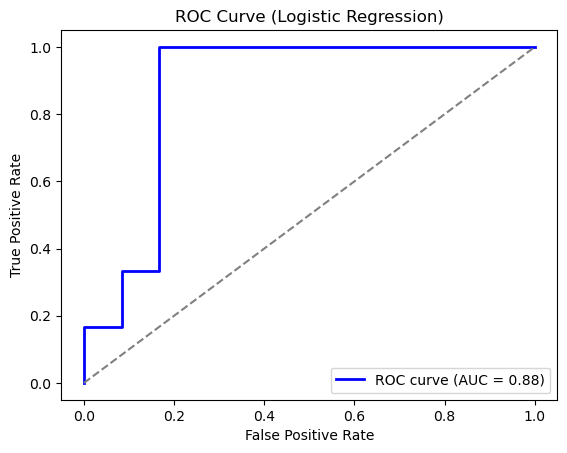

In [95]:
# 5. ROC Curve
# True & Predict
y_true = df_use[y_col]
y_score = fit.predict(df_use)   # Using statsmodels' predict directly

# Caluculate ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = roc_auc_score(y_true, y_score)

# Plotting
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # the baseline of randomly guessing 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Logistic Regression)')
plt.legend(loc="lower right")
plt.show()

[Best F1] t=0.375 | F1=0.857, P=0.750, R=1.000
[Best Youden-J（ROC threshold）] t=0.442 | TPR=1.000, FPR=0.167, J=0.833


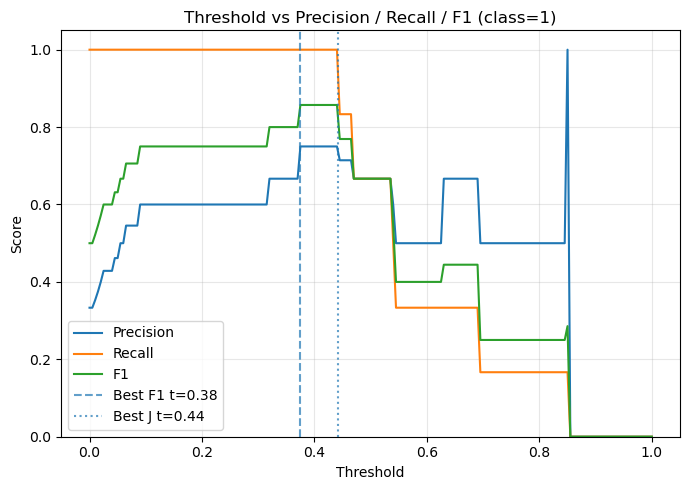

In [97]:
# 6. Calculate Threshhold
# 1) Getting True Results & Predictive Results
y_true  = df_use[y_col].astype(int).values
y_score = fit.predict(df_use)                 # statsmodels Logit：the probability of returning 1

# 2) Scan thresholds from 0 to 1 in increments of 0.005
thresholds = np.linspace(0.00, 1.00, 201)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (y_score >= t).astype(int)
    precisions.append(precision_score(y_true, y_pred, zero_division=0))
    recalls.append(recall_score(y_true, y_pred, zero_division=0))
    f1s.append(f1_score(y_true, y_pred, zero_division=0))

precisions = np.array(precisions)
recalls    = np.array(recalls)
f1s        = np.array(f1s)

# 3) Two common optimal thresholds
best_f1_idx = int(np.argmax(f1s))
best_f1_t   = float(thresholds[best_f1_idx])

fpr, tpr, roc_ts = roc_curve(y_true, y_score)
youden = tpr - fpr
best_j_idx = int(np.argmax(youden))
best_j_t   = float(roc_ts[best_j_idx])

print(f"[Best F1] t={best_f1_t:.3f} | "
      f"F1={f1s[best_f1_idx]:.3f}, P={precisions[best_f1_idx]:.3f}, R={recalls[best_f1_idx]:.3f}")
print(f"[Best Youden-J（ROC threshold）] t={best_j_t:.3f} | "
      f"TPR={tpr[best_j_idx]:.3f}, FPR={fpr[best_j_idx]:.3f}, J={youden[best_j_idx]:.3f}")

# 4) Plotting：Threshold vs Precision / Recall / F1
plt.figure(figsize=(7,5))
plt.plot(thresholds, precisions, label="Precision")
plt.plot(thresholds, recalls,    label="Recall")
plt.plot(thresholds, f1s,        label="F1")

# Reference lines: optimal F1 and optimal Youden’s J
plt.axvline(best_f1_t, ls="--", alpha=0.7, label=f"Best F1 t={best_f1_t:.2f}")
plt.axvline(best_j_t,  ls=":",  alpha=0.7, label=f"Best J t={best_j_t:.2f}")

plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Precision / Recall / F1 (class=1)")
plt.ylim(0, 1.05)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

False Positives： ['Hirokazu Sawamura', 'Tomoyuki Sugano']

False Positives：
                   prob_above  pre_lob_pct  pre_hr_per_fb_pct  mlb_fip_3yr
player_name                                                               
Hirokazu Sawamura    0.625178        0.824              0.060     4.653488
Tomoyuki Sugano      0.849536        0.843              0.033     4.900000


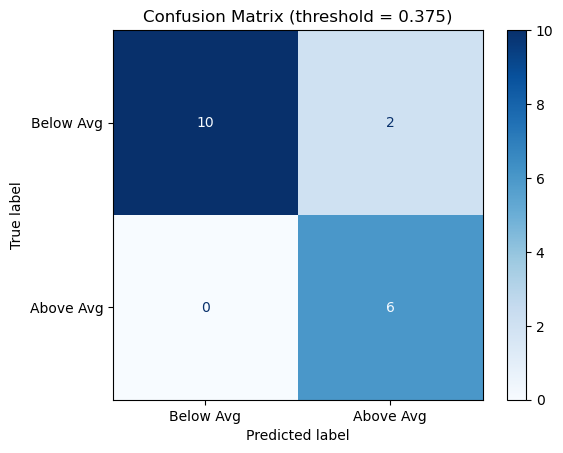

In [99]:
# 7. Confusion Matrix Heatmap  ===> t = 0.375 [F1 Threshold]
# Prediction
y_pred = (y_score >= 0.375).astype(int)

# Changed to numpy array
y_true_arr = np.array(y_true)
y_pred_arr = np.array(y_pred)

# False Positive mask:
fp_mask = (y_true_arr == 0) & (y_pred_arr == 1)

# Getting the two FPs' players names
fp_names = df_use.index[fp_mask].tolist()

print("False Positives：", fp_names)

# The data of False-Positive players: probability, LOB%, HR/FB, and MLB FIP

y_score_arr = np.array(y_score)
fp_detail = df_use.iloc[fp_mask].copy()
fp_detail["prob_above"] = y_score_arr[fp_mask]

cols_to_show = ["prob_above", "pre_lob_pct", "pre_hr_per_fb_pct", "mlb_fip_3yr"]

print("\nFalse Positives：")
print(fp_detail[cols_to_show])

cm = confusion_matrix(y_true, y_pred)

# Plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Below Avg", "Above Avg"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (threshold = 0.375)")
plt.show()

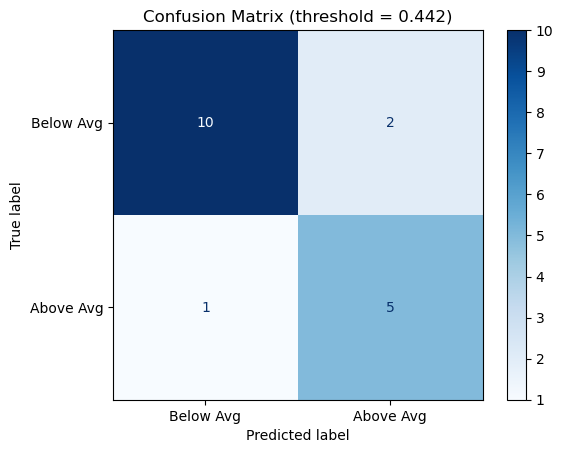

In [105]:
## t = 0.442 [Youden’s J threshold]: Not Using this one since its predictive ability is worse than F1 threshold:
y_pred = (y_score >= 0.442).astype(int)
cm = confusion_matrix(y_true, y_pred)

# Plotting
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Below Avg", "Above Avg"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix (threshold = 0.442)")
plt.show()

In [109]:
# 2026 NPB Prospects Projection
df_pros = pd.read_csv("Potential_Pitchers.csv", index_col = "player_name")
df_pros

,pre_hr_per_fb_pct,pre_lob_pct
player_name,,
Tatsuya Imai,0.037,0.817
Kona Takahashi,0.058,0.777
Kaima Taira,0.000,0.852
Hiroya Miyagi,0.039,0.798
Hiroto Saiki,0.027,0.871
Takahashi Hiroto,0.067,0.772


In [111]:
# Put in the Model
proba = fit.predict(df_pros)               
df_pros["p_above"] = proba

# Classification based on my threshold
t_f1 = 0.375                             
df_pros["above_avg"] = (df_pros["p_above"] >= t_f1).astype(int)

# Ranking 
df_pros["rank"] = df_pros["p_above"].rank(ascending=False).astype(int)
cols = ["rank","p_above", "above_avg", "pre_hr_per_fb_pct", "pre_lob_pct"]
df_pros = df_pros[cols].sort_values(by = "rank")

df_pros.round(3)

,rank,p_above,above_avg,pre_hr_per_fb_pct,pre_lob_pct
player_name,,,,,
Hiroto Saiki,1,0.955,1,0.027,0.871
Kaima Taira,2,0.930,1,0.000,0.852
Tatsuya Imai,3,0.626,1,0.037,0.817
Hiroya Miyagi,4,0.411,1,0.039,0.798
Kona Takahashi,5,0.174,0,0.058,0.777
Takahashi Hiroto,6,0.129,0,0.067,0.772


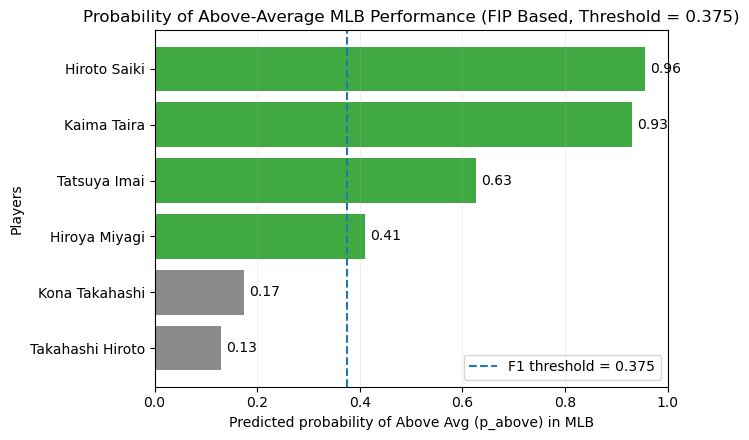

In [113]:
# Plotting 
plot_df = df_pros.sort_values('p_above')

colors = np.where(plot_df['p_above'] >= t_f1, 'tab:green', 'tab:gray')

plt.figure(figsize=(7, 4.5))
bars = plt.barh(plot_df.index, plot_df['p_above'], color=colors, alpha=0.9)

# Tagging numbers
for b in bars:
    w = b.get_width()
    plt.text(w + 0.01, b.get_y() + b.get_height()/2,
             f"{w:.2f}", va='center', fontsize=10)

# F1 Threshold 
plt.axvline(t_f1, color='tab:blue', ls='--', lw=1.5, label=f"F1 threshold = {t_f1:.3f}")

plt.xlim(0, 1)
plt.xlabel("Predicted probability of Above Avg (p_above) in MLB")
plt.ylabel("Players")
plt.title("Probability of Above-Average MLB Performance (FIP Based, Threshold = 0.375)")
plt.legend(loc='lower right')
plt.grid(axis='x', alpha=0.2)
plt.tight_layout()
plt.show()